In [154]:
import random
import numpy as np
import random
import gymnasium as gym
import glob
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from tqdm import tqdm

In [155]:
#Setting up the environment
env = gym.make('Taxi-v3', render_mode="ansi")

env.reset()

#Current State
print(env.unwrapped.s)

# 5x5x5x4 grid = 500 states
print ("Number of states:", env.observation_space.n)
#int state== ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination

# Primitive Actions
action = ["south", "north", "east", "west","pick","drop"]
#correspond to [0,1,2,3,4,5] that's actually passed to the environment


print ("Number of actions that an agent can take:", env.action_space.n)

# Example Transitions
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal,_, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)

state, _ = env.reset()
print(state, 'state')
print ("Decoded state:", list(env.unwrapped.decode(state)))


286
Number of states: 500
Number of actions that an agent can take: 6
Action taken: east
Transition probability: {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
Next state: 286
Reward recieved: -1
Terminal state: False
201 state
Decoded state: [2, 0, 0, 1]


In [156]:

def egreedy_policy(q_values,xy,epsilon):
    if random.random()>epsilon and q_values[xy].any():
        
        action=np.argmax(q_values[xy])
    else:
        action = random.randint(0, q_values.shape[-1]-1)

    return action

goal= {0:[0,0], 1:[0,4], 2:[4,0], 3:[4,3]}

In [157]:
def Substates(state, nPas = 5, nDrop = 4):
  _,_,pas,drop = env.decode(state) 
  subState = nDrop*pas+drop 
  return subState 

In [158]:
#IOQL Learning
def IOQL(env,alpha = 0.65):
    env = env
    gamma = 0.9
    alpha = 0.65
    pas_locs = 5
    drop_locs = 4
    num_options= 4
    q_IOQL= np.zeros((pas_locs*drop_locs, 4))
    updatefreq_IOQL= np.zeros((pas_locs*drop_locs, 4))
    Qopt_IOQL= {i:np.zeros((25,6)) for i in range(num_options)}

    eps_decay= 0.99
    eps_main= 0.5
    eps_min= 0.01

    eps= [0.01, 0.01, 0.01, 0.01]
    IOQL_rew= []
    IOQL_avg=[]
    IOQL_avg_history=[]
    for i in tqdm(range(5000)):
        state,_= env.reset()
        done= False
        total_reward= 0
        
        while not done:
            substate = Substates(state)
            option_chosen= egreedy_policy(q_IOQL, substate, eps_main)

            eps_main= max(eps_min, eps_decay*eps_main)
            optdone= False
            s= state
            reward_bar =0

            
            while optdone == False and not done:
                x,y,pas,drop= env.unwrapped.decode(state)
                if x== goal[option_chosen][0] and y== goal[option_chosen][1]:
                    
                
                    optdone= True
                    if pas == option_chosen:
                    
                        optact= 4
                    elif drop == option_chosen :
                    
                        optact= 5
                    else:
                        optact = 1 if (option_chosen in [0,1]) else 0
                else:
                    optdone= False
                    optact= egreedy_policy(Qopt_IOQL[option_chosen], 5*x + y, eps[option_chosen])
                    eps[option_chosen]= max(eps_min, eps_decay* eps[option_chosen])
                    
                next_state, reward, done1,done2, _= env.step(optact)
                

                done= done1 + done2
                reward_bar= gamma*reward_bar + reward
                total_reward = total_reward + reward
            
                
                if optact < 6: ## update Q table for options using Q learning update
                    x_next, y_next, _, _ = env.unwrapped.decode(next_state)
                    sub_next_state = Substates(next_state)
                
                    Qopt_IOQL[option_chosen][5*x + y, optact] += alpha*(reward + gamma*(np.max(Qopt_IOQL[option_chosen][5*x_next + y_next]) - Qopt_IOQL[option_chosen][5*x + y, optact]))

                for opt in range(num_options): ##update Q-IOQL of other options with experience of present option
                    x,y,pas,drop= env.unwrapped.decode(state)
                    if x== goal[opt][0] and y== goal[opt][1]:
                        
                    
                        optdone_opt= True
                        if pas == opt:
                        
                            optact_opt= 4
                        elif drop == opt :
                        
                            optact_opt= 5
                        else:
                            optact_opt = 1 if (opt in [0,1]) else 0
                            
                    else:
                        optdone_opt = False
                        optact_opt = egreedy_policy(Qopt_IOQL[opt], 5*x + y, eps[opt])
                        eps[opt]= max(eps_min, eps_decay* eps[opt])
                        
                    if optact_opt == optact:
                        eps[opt] = max(eps_min,eps_decay*eps[opt])
                        u = ((1-optdone)*q_IOQL[sub_next_state, opt]) + (optdone*np.max(q_IOQL[sub_next_state,:]))
                        q_IOQL[substate, opt] += alpha*(reward + gamma*u - q_IOQL[substate, opt])
                        updatefreq_IOQL[substate, opt] += 1
                        
                
                state = next_state
                
            
        IOQL_rew.append(total_reward)
        IOQL_avg= np.mean(IOQL_rew[-100:])
        IOQL_avg_history.append(IOQL_avg)
    return IOQL_avg_history,Qopt_IOQL,q_IOQL
        

In [159]:
IOQL_avg_history,Qopt_IOQL,q_IOQL = IOQL(env=env, alpha =0.1)

100%|██████████| 5000/5000 [00:06<00:00, 765.47it/s]


In [160]:
# SMDP learning
def SMDP(env,alpha = 0.1):
    gamma = 0.9
    pas_locs = 5
    drop_locs = 4
    num_options= 4
    q_SMDP= np.zeros((pas_locs*drop_locs, 4))
    updatefreq_SMDP= np.zeros((pas_locs*drop_locs, 4))
    Qopt_SMDP= {i:np.zeros((25,6)) for i in range(num_options)}

    eps_decay= 0.99
    eps_main= 0.5
    eps_min= 0.01

    eps= [0.01, 0.01, 0.01, 0.01]
    SMDP_rew = []
    SMDP_avg= []
    SMDP_avg_history=[]
    for i in tqdm(range(5000)):
        state,_= env.reset()
        done= False
        total_reward= 0
        
        while not done:
            substate = Substates(state)
            option_chosen= egreedy_policy(q_SMDP, substate, eps_main)
    
            eps_main= max(eps_min, eps_decay*eps_main)
            optdone= False
            s= state
            reward_bar =0
            k=0
            
            while optdone == False and not done:
                x,y,pas,drop= env.unwrapped.decode(state)
                
                if x== goal[option_chosen][0] and y== goal[option_chosen][1]:
                    
                
                    optdone= True
                    if pas == option_chosen:
                    
                        optact= 4
                    elif drop == option_chosen :
                    
                        optact= 5
                    else:
                        optact = 1 if (option_chosen in [0,1]) else 0
                else:
                    optdone= False
                    optact= egreedy_policy(Qopt_SMDP[option_chosen], 5*x + y, eps[option_chosen])
                    eps[option_chosen]= max(eps_min, eps_decay* eps[option_chosen])
                    
                next_state, reward, done1, done2,_= env.step(optact)#
                done= done1 + done2

                
                reward_bar= gamma*reward_bar + reward
                k+=1
                total_reward = total_reward + reward
                
                
                if optact < 6:
                    x_next, y_next, _, _ = env.unwrapped.decode(next_state)
                    sub_next_state = Substates(next_state)
                    Qopt_SMDP[option_chosen][5*x + y, optact] += alpha*(reward + gamma*(np.max(Qopt_SMDP[option_chosen][5*x_next + y_next]) - Qopt_SMDP[option_chosen][5*x + y, optact]))
                
                
                state = next_state

            subnextState = Substates(state) ## converting to pas*drop location format to update q_SMDP
            subprevState = Substates(s)  
            #SMDP update done after completion of option
            q_SMDP[subprevState][option_chosen] += alpha*(reward_bar + (gamma**k)*(np.max(q_SMDP[subnextState])- q_SMDP[subprevState][option_chosen]))
            updatefreq_SMDP[subprevState][option_chosen] += 1
        
            
        SMDP_rew.append(total_reward)
        SMDP_avg= np.mean(SMDP_rew[-100:])
        SMDP_avg_history.append(SMDP_avg)
    return SMDP_avg_history,Qopt_SMDP,q_SMDP

In [161]:
SMDP_avg_history,Qopt_SMDP,q_SMDP = SMDP(env=env, alpha =0.1)

100%|██████████| 5000/5000 [00:04<00:00, 1200.38it/s]


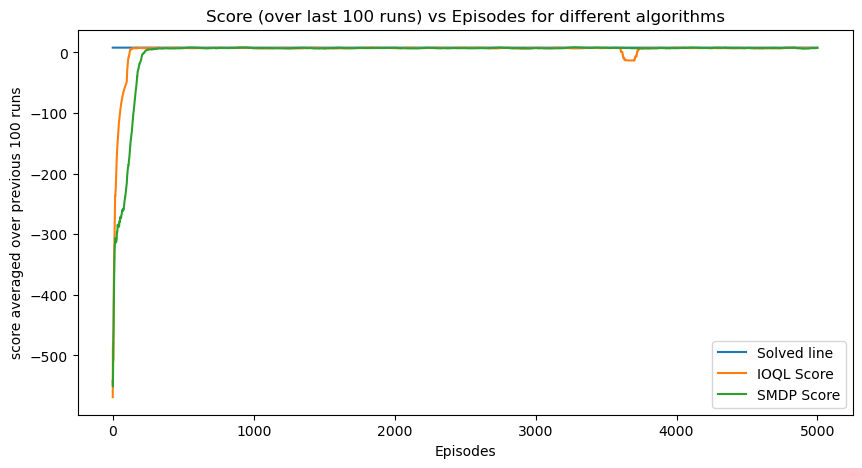

In [162]:
plt.figure(figsize = (10,5))

plt.plot([8 for i in range(5000)],label = 'Solved line')
plt.plot(IOQL_avg_history,label = 'IOQL Score')

plt.plot(SMDP_avg_history,label = 'SMDP Score')

plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Score (over last 100 runs) vs Episodes for different algorithms')
plt.legend()

#### Since both the algorithms are learning in less than 500 episodes zooming in for first 500 episodes

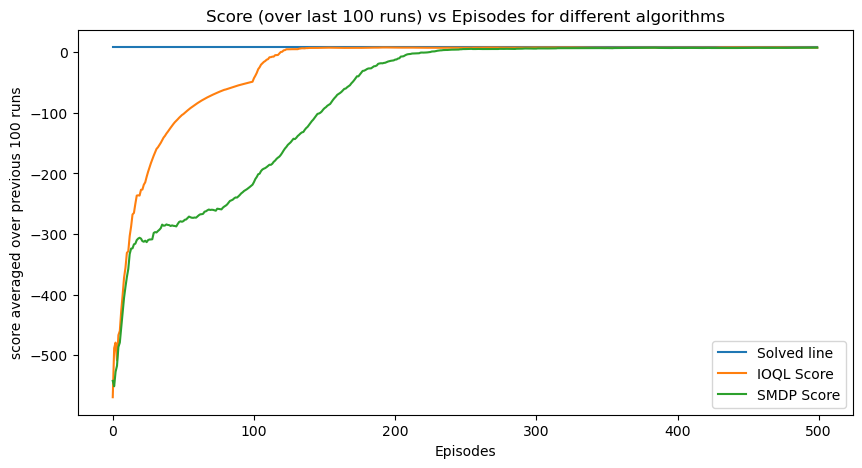

In [163]:
plt.figure(figsize = (10,5))
plt.plot([8 for i in range(500)],label = 'Solved line')
plt.plot(IOQL_avg_history[:500],label = 'IOQL Score')

plt.plot(SMDP_avg_history[:500],label = 'SMDP Score')

plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Score (over last 100 runs) vs Episodes for different algorithms')
plt.legend()

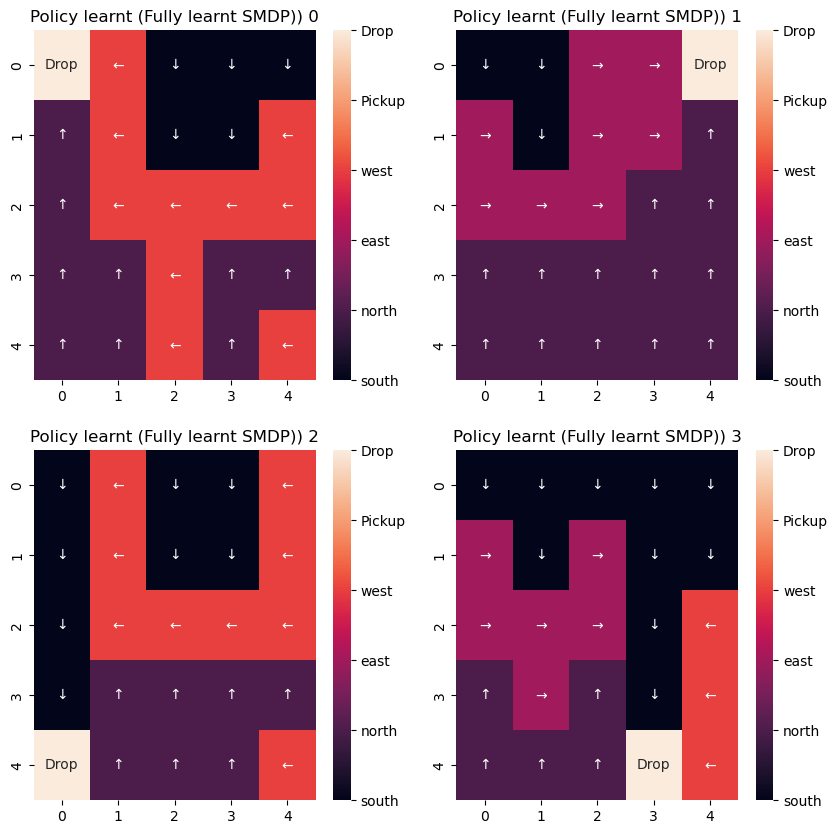

In [164]:
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0: '↓', 1: '↑', 2: '→', 3: '←', 4: 'Pickup', 5: 'Drop'}
    annotation = np.vectorize(labels.get)(np.argmax(Qopt_SMDP[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt_SMDP[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annotation,fmt='')

    axis[i,j].set_title("Policy learnt (Fully learnt SMDP)) {}".format(i*2+j))
    color_bar = ax.collections[0].colorbar
    color_bar.set_ticks([i for i in range(6)])
    color_bar.set_ticklabels(['south','north','east','west','Pickup','Drop'])

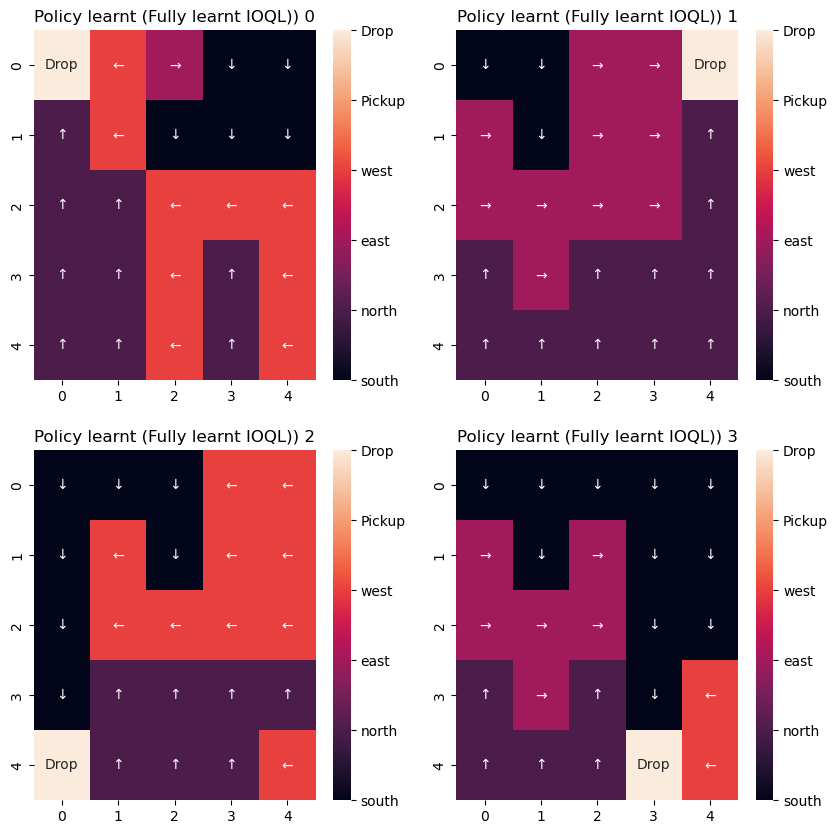

In [165]:
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0: '↓', 1: '↑', 2: '→', 3: '←', 4: 'Pickup', 5: 'Drop'}
    annotation = np.vectorize(labels.get)(np.argmax(Qopt_IOQL[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt_IOQL[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annotation,fmt='')

    axis[i,j].set_title("Policy learnt (Fully learnt IOQL)) {}".format(i*2+j))
    color_bar = ax.collections[0].colorbar
    color_bar.set_ticks([i for i in range(6)])
    color_bar.set_ticklabels(['south','north','east','west','Pickup','Drop'])

Text(0.5, 1.0, 'Policy learnt by SMDP')

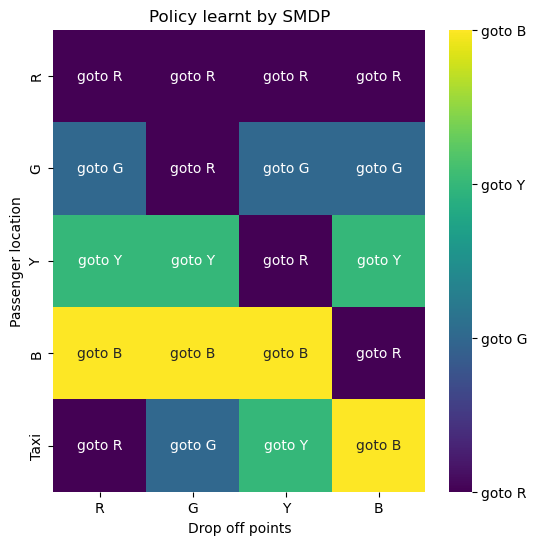

In [166]:
import matplotlib as mpl
Qmax_SMDP = np.argmax(q_SMDP,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annotation = np.vectorize(labels.get)(Qmax_SMDP)
figure, axis = plt.subplots(1, 1,figsize=(6,6))
ax = sns.heatmap(Qmax_SMDP,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annotation ,fmt = '', cmap  = mpl.colormaps['viridis'])
color_bar = ax.collections[0].colorbar
color_bar.set_ticks([0, 1, 2, 3])
color_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])

axis.set_xlabel('Drop off points')

axis.set_ylabel("Passenger location")

axis.set_title('Policy learnt by SMDP')

Text(0.5, 1.0, 'Policy learnt by IOQL')

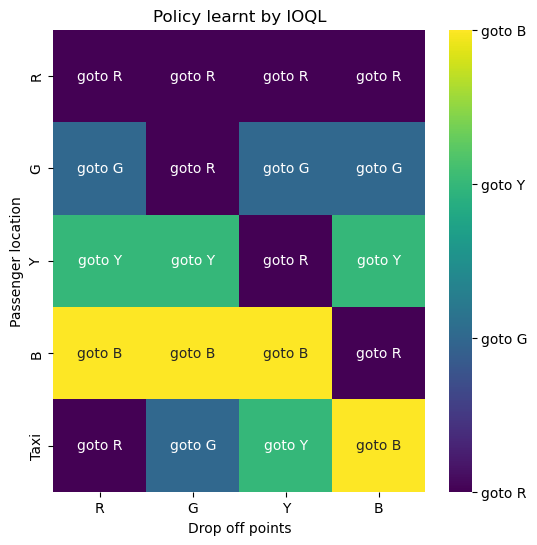

In [167]:
import matplotlib as mpl
Qmax_IOQL = np.argmax(q_IOQL,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annotation = np.vectorize(labels.get)(Qmax_IOQL)
figure, axis = plt.subplots(1, 1,figsize=(6,6))
ax = sns.heatmap(Qmax_IOQL,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annotation,fmt = '', cmap  = mpl.colormaps['viridis'])
color_bar = ax.collections[0].colorbar
color_bar.set_ticks([0, 1, 2, 3])
color_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])

axis.set_xlabel('Drop off points')

axis.set_ylabel("Passenger location")

axis.set_title('Policy learnt by IOQL')

### New Options 2

In [168]:
# Options
##New options going North till it reaches extreme, and South till it reaches extreme. North and south are chosen instead of east and west due to presence of barriers in E-W navigation
def Keep_North(env,state):
    x,y,pas,drop= env.unwrapped.decode(state)
    if pas != 4:
      if x== goal[pas][0] and y== goal[pas][1]: ##if it reaches either pick/drop location, execute pick/drop
         optact = 4
         optdone=True
      if x== goal[drop][0] and y== goal[drop][1]:
         optact = 5
         optdone=True
    optdone = False
    optact = 1
    if x == 0: ## executed when reaches northmost (x,y are interchanged in this state definition of taxi-v3)
        optdone = True
    return optact,optdone

def Keep_South(env,state):
    
    x,y,pas,drop= env.unwrapped.decode(state)
    if pas != 4:
      if x== goal[pas][0] and y== goal[pas][1]:
         optact = 4
         optdone=True
      if x== goal[drop][0] and y== goal[drop][1]:
         optact = 5
         optdone=True
    optdone = False
    optact = 0
    if x == 4:
        optdone = True ## executed when reaches the southmost row
    return optact,optdone


In [169]:
def egreedy_policy_new(q_values,xy,epsilon):
    if random.random()>epsilon and q_values[xy].any():
        
        action= np.argmax(q_values[xy])
    else:
        action = random.randint(0, q_values.shape[-1]-1)

    return action

In [170]:
def SMDP_new(env,alpha = 0.1):
    gamma = 0.9
    pas_locs = 5
    drop_locs = 4
    num_options= 2 #going north and south
    q_SMDP_new= np.zeros((pas_locs*drop_locs,8)) ##we choose SMDP policy also from primitive actions, otherwise reaching goal is difficult, hence no. of actions= 6+2
    updatefreq_SMDP_new = np.zeros((pas_locs*drop_locs, 8))
    Qopt_SMDP_new = {i:np.zeros((25,6)) for i in range(num_options)}

    eps_decay= 0.99
    eps_main= 0.5
    eps_min= 0.01

    eps= [0.01, 0.01, 0.01, 0.01]
    SMDP_rew_new = []
    SMDP_avg_new= []
    SMDP_avg_history_new=[]
    for i in tqdm(range(3000)):
        state,_= env.reset()
        done= False
        total_reward= 0
        
        while not done:
            x,y,pas,drop= env.unwrapped.decode(state)
            substate = Substates(state)
            action = egreedy_policy(q_SMDP_new, substate, eps_main)
        # option_chosen= pas
            eps_main= max(eps_min, eps_main*eps_decay)
            optdone= False
            s= state
            reward_bar =0
            k=0

            if action < 6:
                next_state, reward, done1,done2, _= env.step(action)
                sub_next_state = Substates(next_state)
                done = done1+done2
                q_SMDP_new[substate][action] += alpha*(reward + (gamma)*np.max(q_SMDP_new[sub_next_state])- q_SMDP_new[substate][action])
                
                updatefreq_SMDP_new[substate][action]+=1
                state= next_state
                total_reward += reward

            elif action == 6:
                 option_chosen = action - 6
                 k = 0
                 updatefreq_SMDP_new[substate][4]+=1
                 optdone  = False
                 while not optdone and not done:
                     x,y,_,_= env.unwrapped.decode(state)
                     k+=1
                     optact,optdone = Keep_North(env,state)
                     next_state, reward,done1,done2,_ = env.step(optact)
                     x_next,y_next,_,_= env.unwrapped.decode(next_state)
                     sub_next_state = Substates(next_state)
                     done = done1 + done2 
                     reward_bar = gamma*reward_bar + reward
                     Qopt_SMDP_new[option_chosen][5*x + y, optact] += alpha*(reward + gamma*(np.max(Qopt_SMDP_new[option_chosen][5*x_next + y_next]) - Qopt_SMDP_new[option_chosen][5*x + y, optact]))
                     state = next_state
                 q_SMDP_new[substate][action] += alpha*(reward_bar + (gamma**k)*(np.max(q_SMDP_new[sub_next_state])- q_SMDP_new[substate][action]))
            
            elif action == 7:
                 option_chosen = action - 6
                 k = 0
                 updatefreq_SMDP_new[substate][5]+=1
                 optdone  = False
                 while not optdone and not done:
                     x,y,_,_= env.unwrapped.decode(state)
                     k+=1
                     optact,optdone = Keep_South(env,state)
                     next_state, reward,done1,done2,_ = env.step(optact)
                     x_next,y_next,_,_= env.unwrapped.decode(next_state)
                     sub_next_state = Substates(next_state)
                     done = done1 + done2 
                     reward_bar = gamma*reward_bar + reward
                     Qopt_SMDP_new[option_chosen][5*x + y, optact] += alpha*(reward + gamma*(np.max(Qopt_SMDP_new[option_chosen][5*x_next + y_next]) - Qopt_SMDP_new[option_chosen][5*x + y, optact]))
                     state = next_state
                 q_SMDP_new[substate][action] += alpha*(reward_bar + (gamma**k)*(np.max(q_SMDP_new[sub_next_state])- q_SMDP_new[substate][action]))
                 
                     

            
            
            
        SMDP_rew_new.append(total_reward)
        SMDP_avg_new= np.mean(SMDP_rew_new[-100:])
        SMDP_avg_history_new.append(SMDP_avg_new)
    return SMDP_avg_history_new,Qopt_SMDP_new,q_SMDP_new

In [194]:
SMDP_avg_history_new,Qopt_SMDP_new,q_SMDP_new = SMDP_new(env=env, alpha =0.15)

  0%|          | 0/3000 [00:00<?, ?it/s]c:\Users\beher\anaconda3\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 3000/3000 [00:33<00:00, 88.56it/s] 


In [173]:
def IOQL_new(env,alpha = 0.1):
    gamma = 0.9
    pas_locs = 5
    drop_locs = 4
    num_options= 2
    q_IOQL_new= np.zeros((pas_locs*drop_locs,8))
    updatefreq_IOQL_new = np.zeros((pas_locs*drop_locs, 8))
    Qopt_IOQL_new = {i:np.zeros((25,6)) for i in range(num_options)}

    eps_decay= 0.99
    eps_main= 0.5
    eps_min= 0.01

    IOQL_rew_new = []
    IOQL_avg_new= []
    IOQL_avg_history_new=[]
    for i in tqdm(range(3000)):
        state,_= env.reset()
        done= False
        total_reward= 0
        
        while not done:
            x,y,pas,drop= env.unwrapped.decode(state)
            substate = Substates(state)
            action = egreedy_policy(q_IOQL_new, substate, eps_main)
        # option_chosen= pas
            eps_main= max(eps_min, eps_main*eps_decay)
            optdone= False
            s= state
            reward_bar =0
            k=0
            

            if action < 6:
                next_state, reward, done1,done2, _= env.step(action)
                sub_next_state = Substates(next_state)
                done = done1+done2
                q_IOQL_new[substate][action] += alpha*(reward + (gamma)*np.max(q_IOQL_new[sub_next_state])- q_IOQL_new[substate][action])
                updatefreq_IOQL_new[substate][action]+=1
                state= next_state
                total_reward += reward

            elif action == 6:
                 option_chosen = action - 6
                 k = 0
                 optdone  = False
                 while not optdone and not done:
                     x,y,_,_= env.unwrapped.decode(state)
                     k+=1
                     optact,optdone = Keep_North(env,state)
                     next_state, reward,done1,done2,_ = env.step(optact)
                     x_next,y_next,_,_= env.unwrapped.decode(next_state)
                     sub_next_state = Substates(next_state)
                     done = done1 + done2 
                     Qopt_IOQL_new[option_chosen][5*x + y, optact] += alpha*(reward + gamma*(np.max(Qopt_IOQL_new[option_chosen][5*x_next + y_next]) - Qopt_IOQL_new[option_chosen][5*x + y, optact]))
                     u = ((1-optdone)*q_IOQL_new[sub_next_state, action]) + (optdone*np.max(q_IOQL_new[sub_next_state,:]))
                     q_IOQL_new[substate,action] += alpha*(reward + gamma*u - q_IOQL_new[substate, action])
                     updatefreq_IOQL_new[substate, action] += 1
                     state = next_state
                     
            
            elif action == 7:
                 option_chosen = action - 6
                 k = 0
                 updatefreq_IOQL_new[substate][4]+=1
                 optdone  = False
                 while not optdone and not done:
                     x,y,pas,drop= env.unwrapped.decode(state)
                     k+=1
                     optact,optdone = Keep_South(env,state)
                     next_state, reward,done1,done2,_ = env.step(optact)
                     x_next,y_next,_,_= env.unwrapped.decode(next_state)
                     sub_next_state = Substates(next_state)
                     done = done1 + done2 
                     reward_bar = gamma*reward_bar + reward
                     Qopt_IOQL_new[option_chosen][5*x + y, optact] += alpha*(reward + gamma*(np.max(Qopt_IOQL_new[option_chosen][5*x_next + y_next]) - Qopt_IOQL_new[option_chosen][5*x + y, optact]))
                     u = ((1-optdone)*q_IOQL_new[sub_next_state, action]) + (optdone*np.max(q_IOQL_new[sub_next_state,:]))
                     q_IOQL_new[substate, action] += alpha*(reward + gamma*u - q_IOQL_new[substate, action])
                     updatefreq_IOQL_new[substate, action] += 1
                     state = next_state
                     
                 
                 
                     

            
            
            
        IOQL_rew_new.append(total_reward)
        IOQL_avg_new= np.mean(IOQL_rew_new[-100:])
        IOQL_avg_history_new.append(IOQL_avg_new)
    return IOQL_avg_history_new,Qopt_IOQL_new,q_IOQL_new

In [187]:
IOQL_avg_history_new,Qopt_IOQL_new,q_IOQL_new = IOQL_new(env=env, alpha = 0.1)

100%|██████████| 3000/3000 [00:30<00:00, 98.75it/s] 


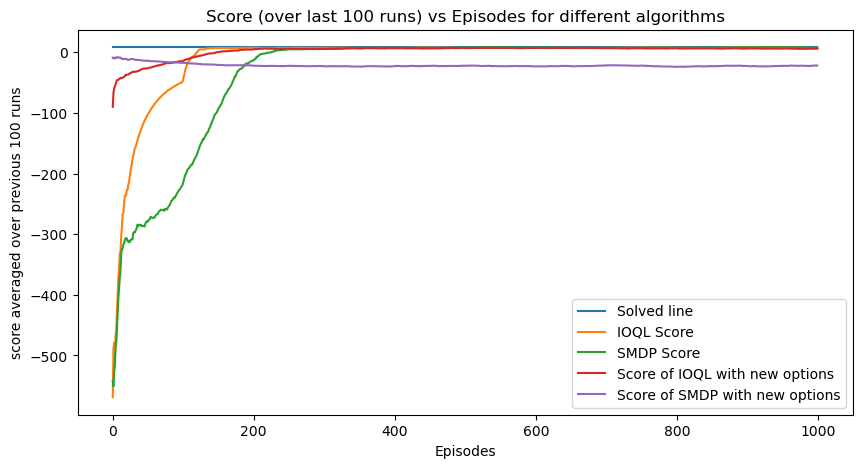

In [193]:
plt.figure(figsize = (10,5))
plt.plot([8 for i in range(1000)],label = 'Solved line')
plt.plot(IOQL_avg_history[:1000],label = 'IOQL Score')
plt.plot(SMDP_avg_history[:1000],label = 'SMDP Score')
plt.plot(IOQL_avg_history_new[:1000],label = 'Score of IOQL with new options')
plt.plot(SMDP_avg_history_new[:1000],label = 'Score of SMDP with new options')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('Score (over last 100 runs) vs Episodes for different algorithms')
plt.legend()